In [ ]:
!gsutil -m cp -r gs://original-data-amli/AMLI-newtrashnet/ ./

In [10]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [ ]:
os.listdir(os.path.join(os.getcwd(),"AMLI-newtrashnet"))

In [26]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = os.listdir(f'./AMLI-newtrashnet/{waste_type}')
    #file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.copy(file,destination_folder)

In [27]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

# create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data2',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data2','test')):
    os.makedirs(os.path.join('data2','test'))
     

In [41]:
       
# move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('AMLI-newtrashnet',waste_type)
    #train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    # get filenames
    file_names = os.listdir(f'./AMLI-newtrashnet/{waste_type}')
    random.shuffle(file_names)
    waste_type_size = len(file_names)
    train_ind = int(0.5*waste_type_size)
    test_ind = int(0.75*waste_type_size)
    
    ## move source files to train
    train_names = file_names[:train_ind]
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data2/train/"+waste_type
    move_files(train_source_files,train_dest)

    ## move source files to valid
    valid_names = file_names[test_ind:]
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data2/valid/"+waste_type
    move_files(valid_source_files,valid_dest)

    ## move source files to test
    test_names = file_names[train_ind:test_ind]
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data2/test")

In [5]:
## get a path to the folder with images
path = Path(os.getcwd())/"data2"
path

PosixPath('/home/jupyter/data2')

In [6]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

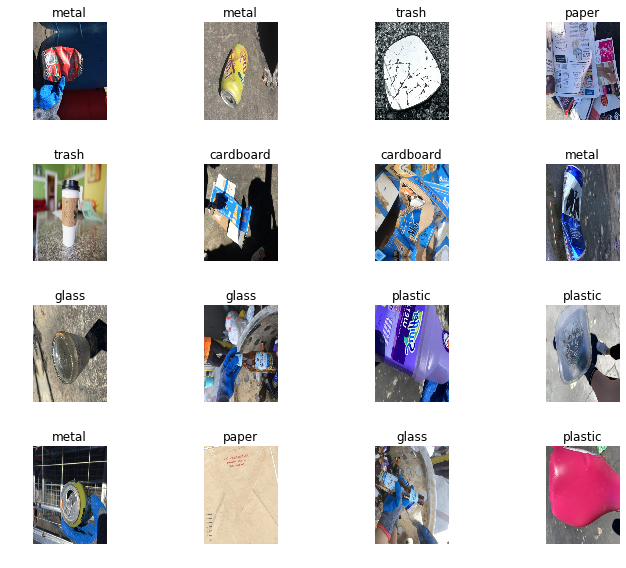

In [7]:
data.show_batch(rows=4,figsize=(10,8))

In [12]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

In [ ]:
learn.load('first_recycle_model')

In [42]:
preds, target = learn.get_preds()
print('Validation Accuracy: ',accuracy(preds, target).item())

Validation Accuracy:  0.3844393491744995


In [43]:
preds, target = learn.get_preds(ds_type=DatasetType.Test)
print('Test Accuracy: ',accuracy(preds, target).item())

Test Accuracy:  0.26728111505508423


In [44]:
preds, target = learn.TTA()
print('Validation Accuracy: ',accuracy(preds, target).item())

Validation Accuracy:  0.44622424244880676
